In [39]:
import geopandas as gpd
import pandas as pd
from plotly import express as px
import statsmodels.api as sm

from data.constants import WEB_CRS

In [40]:
tract_file_in = "../data/interim/tracts.geoparquet"
comm_file_in = "../data/interim/communities.geojson"

point_panel_in = "../data/final/point_panel.parquet"
line_panel_in = "../data/final/line_panel.parquet"
tract_panel_in = "../data/final/tract_panel.parquet"
comm_panel_in = "../data/final/comm_panel.parquet"

# Pipeline in

In [41]:
tracts = gpd.read_parquet(tract_file_in)
comms = gpd.read_file(comm_file_in)

point_panel = pd.read_parquet(point_panel_in)
line_panel = pd.read_parquet(line_panel_in)
tract_panel = pd.read_parquet(tract_panel_in)
comm_panel = pd.read_parquet(comm_panel_in)

In [42]:
point_panel_wkd = point_panel[~point_panel['is_weekend'].astype(bool)]
line_panel_wkd = line_panel[~line_panel['is_weekend'].astype(bool)]
tract_panel_wkd = tract_panel[~tract_panel['is_weekend'].astype(bool)]
comm_panel_wkd = comm_panel[~comm_panel['is_weekend'].astype(bool)]

# Validate

Now that we're using sports, we probably shouldn't kill the weekends.

In [43]:
point_panel.drop_duplicates('date').is_weekend.value_counts()

is_weekend
False    84
True     46
Name: count, dtype: int64

As we saw in 4.3-profile-data.ipynb, these dates are really sparse. And sort of disjoint.

In [44]:
plot_data = point_panel.groupby(['date','stadium'],as_index=False)['attendance'].sum().pivot(index='date', columns='stadium', values='attendance')
px.imshow(plot_data)

In [45]:
def count_ids(df):
    return df.groupby(['id','transit']).size().count()

In [46]:
def plot_avg_completion(df):
    n_ids = count_ids(df)
    plot_data = df.groupby('date',sort=True).apply(count_ids, include_groups=False) / n_ids
    return px.line(x=plot_data.index, y=plot_data, title="panel completion")

In [47]:
def plot_transit_completion(df):
    n_ids = df.groupby('transit')[['transit','id']].apply(count_ids)
    plot_data = (df
             .groupby(['date','transit'],sort=True)
             [['transit','id']]
             .apply(count_ids)
             .rename('count')
             .reset_index()
             .assign(pct = lambda x: x['count']))
            #  .assign(pct = lambda x: x['count'] / x['transit'].map(n_ids)))
    return px.line(plot_data, x='date', y='pct', color='transit',title="panel completion")

In [48]:
def completion_matrix(df,rows,cols):
    df = df.assign(exists=1).groupby([rows,cols])['exists'].any().astype(float)
    return df.reset_index().pivot(index=rows, columns=cols, values='exists').fillna(0)

def completion_long(df, rows, cols):
    mat = completion_matrix(df, rows, cols)
    return mat.reset_index().melt(id_vars=rows, var_name=cols, value_name='exists')

## Completion

The completion charts are crap now. But nothing is 'missing'. It's identical to when
there are games, because that's what we chose.

In [88]:
y1 = point_panel.groupby(['date'],as_index=False)['attendance'].sum()
y2 = point_panel.groupby('date', as_index=False).apply(lambda x: (x['transit']+x['id']).nunique())
y2.columns = ['date','nstations']
y2['nstations'] /= y2['nstations'].mean()
y1['attendance'] /= y1['attendance'].mean()
plot_data = y1.merge(y2).melt(id_vars=['date'])
px.line(plot_data,x='date',y='value',color='variable')

/var/folders/tb/97cmcv3d7756wm9ypglr63nw0000gn/T/ipykernel_98917/3000091354.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [66]:
chart = plot_avg_completion(point_panel)


In [49]:
plot_transit_completion(point_panel)

In [50]:
plot_transit_completion(line_panel)

In [51]:
plot_transit_completion(tract_panel)

# Predict drop-out

In [56]:
def minmax_scale(x):
    return (x - x.min()) / (x.max() - x.min())

def model_completion_data(df):
    model_data = completion_long(df, 'date','id')
    model_data['missing'] = 1 - model_data['exists']
    model_data['datenum'] = pd.to_datetime(model_data['date'],'coerce').apply(lambda x: x.timestamp())
    model_data['datenum'] = model_data['datenum'].pipe(minmax_scale)
    spacelike = df[['id','transit','lat','long']].drop_duplicates()
    spacelike['spacerides'] = spacelike['id'].map(df.groupby('id')['rides'].mean())
    timelike = df[['date','is_weekend']].drop_duplicates()
    timelike['timerides'] = timelike['date'].map(df.groupby('date')['rides'].mean())
    spacetimelike = df[['date','id','rides']].drop_duplicates()
    model_data = model_data.merge(spacelike, how='left')
    model_data = model_data.merge(timelike, how='left')
    model_data = model_data.merge(spacetimelike, how='left')
    model_data['rides'] = model_data['rides'].fillna(0)+1
    return model_data

def model_completion(df, formula=None):
    model_data = model_completion_data(df)
    default_formula = "missing ~ transit + is_weekend + lat + long + I(lat*long) + I(lat**2) + I(long**2)"
    formula = default_formula if formula is None else formula
    return sm.Logit.from_formula(formula, model_data).fit()

In [ ]:
point_missing = model_completion_data(point_panel)
fig = px.scatter_matrix(point_missing, dimensions=['missing','datenum','lat','long'])
fig.update_traces(diagonal_visible=False)
# Now there are going to be spatial patterns of missing data because games are on different days.

In [ ]:
line_missing = model_completion_data(line_panel)
fig = px.scatter_matrix(line_missing, dimensions=['missing','datenum','lat','long'])
fig.update_traces(diagonal_visible=False)
# There is less of a spatial pattern here because lines serve more places.

In [ ]:
tract_missing = model_completion_data(tract_panel)
fig = px.scatter_matrix(tract_missing, dimensions=['missing','datenum','lat','long'])
fig.update_traces(diagonal_visible=False)
# There's a pattern here, but less distinct because tracts are slightly bigger.

In [ ]:
comm_missing = model_completion_data(comm_panel)
fig = px.scatter_matrix(comm_missing, dimensions=['missing','datenum','lat','long'])
fig.update_traces(diagonal_visible=False)
# There's a pattern here, it's the comm areas though.

In [89]:
# Every location is going to miss things because there are not games everyday.
(point_missing.groupby('id')['missing'].any().mean(),
line_missing.groupby('id')['missing'].any().mean(),
tract_missing.groupby('id')['missing'].any().mean(),
comm_missing.groupby('id')['missing'].any().mean())

(np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0))

In [90]:
# There aren't games every day so there will be missing things.
(point_missing.groupby('date')['missing'].any().mean(),
line_missing.groupby('date')['missing'].any().mean(),
tract_missing.groupby('date')['missing'].any().mean(),
comm_missing.groupby('date')['missing'].any().mean())

(np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0))

# Spatial

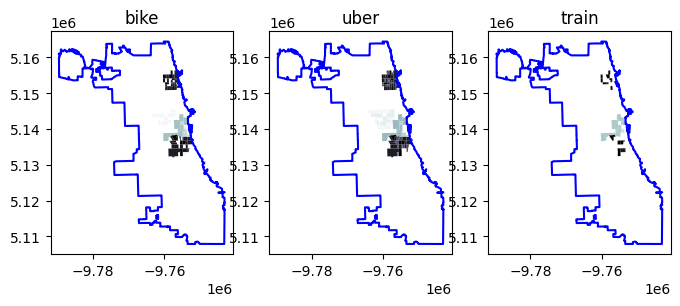

In [ ]:
import matplotlib.pyplot as plt
from data.constants import CHI_BOUNDARY_FILE
plot_data = tract_missing.groupby(['id','transit'])['missing'].mean().reset_index()
plot_data = plot_data.merge(tracts[['geoid10','geometry']],left_on='id',right_on='geoid10')
plot_data = gpd.GeoDataFrame(plot_data, geometry='geometry').to_crs(WEB_CRS)
chi_bound = gpd.read_file(CHI_BOUNDARY_FILE).to_crs(WEB_CRS)
fig, axs = plt.subplots(1, plot_data.transit.nunique(), figsize=(8,8))
for t, ax in zip(plot_data.transit.unique(), axs):
    fig = plot_data[plot_data.transit==t].plot('missing', cmap='bone',ax=ax)
    chi_bound.boundary.plot(ax=fig, color='blue')
    fig.set_title(t)

# Obv we only have data around stadiums.

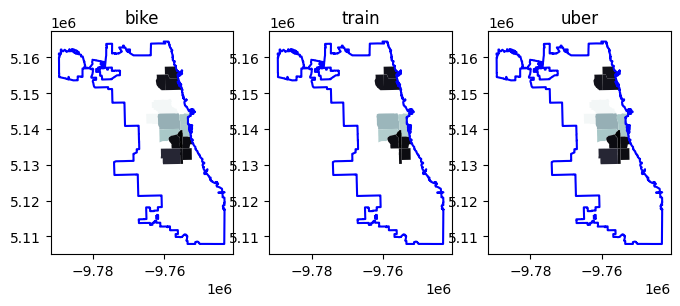

In [ ]:
import matplotlib.pyplot as plt
from data.constants import CHI_BOUNDARY_FILE
plot_data = comm_missing.groupby(['id','transit'])['missing'].mean().reset_index()
plot_data = plot_data.merge(comms[['comm_area','geometry']],left_on='id',right_on='comm_area')
plot_data = gpd.GeoDataFrame(plot_data, geometry='geometry').to_crs(WEB_CRS)
chi_bound = gpd.read_file(CHI_BOUNDARY_FILE).to_crs(WEB_CRS)
fig, axs = plt.subplots(1, plot_data.transit.nunique(), figsize=(8,8))
for t, ax in zip(plot_data.transit.unique(), axs):
    fig = plot_data[plot_data.transit==t].plot('missing', cmap='bone',ax=ax)
    chi_bound.boundary.plot(ax=fig, color='blue')
    fig.set_title(t)

# Obv we only have data around stadiums.

# Interpretation of unbalanced panel

According to Woldridge (p. 491), attrition is ok if it is random and uncorrelated with 
the unobserved error. Also, it's ok for data to be missing due to exogeneous
variables, e.g. E(wage|age > 35). It's not ok for it to be missing due to 
endogenous variable E(wage > 50k|age). 

The sparsity of train census tracts makes me wonder if we should use a voronoi
tesselation or some other larger aerial unit of the population the train is serving.
I'm actually surprised the bus tract coverage is so complete in this regard.